# Clinical NLP Workflow Demonstration

This notebook demonstrates the end-to-end workflow for processing synthetic clinical data:
1. ETL: Load and clean data
2. NLP: Extract disease phenotypes and symptoms
3. Analysis: Visualize and summarize results


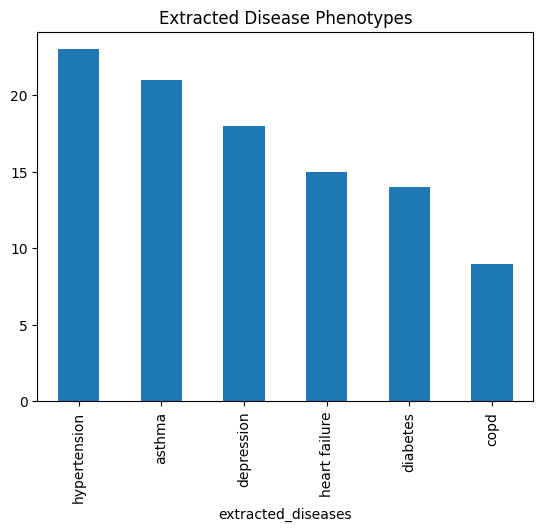

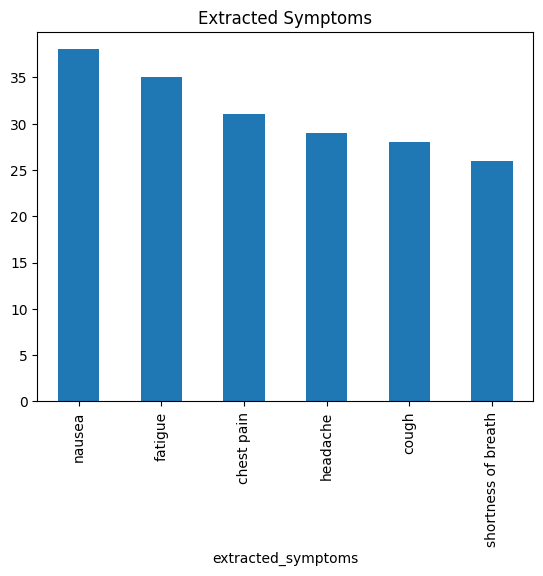

,clinical_note,extracted_diseases,extracted_symptoms
0,Patient presents with cough. History of diabetes.,[diabetes],[cough]
1,"Patient presents with headache, fatigue. Histo...",[asthma],"[fatigue, headache]"
2,Patient presents with chest pain. History of d...,[diabetes],[chest pain]
3,"Patient presents with nausea, headache. Histor...",[hypertension],"[headache, nausea]"
4,Patient presents with fatigue. History of diab...,[diabetes],[fatigue]


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath("../src"))
from etl_pipeline import etl_process
from nlp_pipeline import nlp_process

# Define disease and symptom lists
DISEASES = ["diabetes", "hypertension", "asthma", "copd", "heart failure", "depression"]
SYMPTOMS = ["fatigue", "cough", "chest pain", "shortness of breath", "headache", "nausea"]

# ETL: Load and clean data
df = etl_process("../data/synthetic_clinical_data.csv")

# NLP: Extract phenotypes and symptoms
df = nlp_process(df, DISEASES, SYMPTOMS)

# Analysis: Disease frequency
phenotype_counts = df.explode("extracted_diseases")["extracted_diseases"].value_counts()
phenotype_counts.plot(kind="bar", title="Extracted Disease Phenotypes")
plt.show()

# Analysis: Symptom frequency
symptom_counts = df.explode("extracted_symptoms")["extracted_symptoms"].value_counts()
symptom_counts.plot(kind="bar", title="Extracted Symptoms")
plt.show()

# Show sample results
df[["clinical_note", "extracted_diseases", "extracted_symptoms"]].head()

In [33]:
# Import new advanced modules for clinical NLP workflow
from clinical_ner import tokenize_and_align_labels  # and other NER functions
from clinical_ner import run_advanced_ner
from phenotype_builder import assess_t2d_cohort
from deidentify import deidentify_text

# Example usage in workflow:

# 1. De-identify clinical notes before NLP
df["clinical_note_deid"] = df["clinical_note"].apply(deidentify_text)

# 2. Use advanced NER (fine-tuned model) on de-identified notes
df["entities"] = df["clinical_note_deid"].apply(lambda x: run_advanced_ner(x) if x else [])

# Debug: print available columns to find correct diagnoses column
print(df.columns)  # Check for correct column name, e.g., 'diagnosis', 'dx', etc.

# 3. Build phenotype cohorts using rule-based logic
# Example for T2D:
# Update 'diagnoses' to the correct column name below if needed
df["t2d_cohort"] = df.apply(lambda row: assess_t2d_cohort(row["patient_id"], row.get("diagnoses", row.get("diagnosis", None)), row["clinical_note_deid"], row.get("labs", None)), axis=1)

Index(['patient_id', 'age', 'gender', 'disease', 'symptoms', 'clinical_note',
       'extracted_diseases', 'extracted_symptoms', 'clinical_note_deid',
       'entities'],
      dtype='object')


In [34]:
# Setup for Hugging Face clinical NER fine-tuning
from transformers import AutoTokenizer

# Choose a clinical NER model checkpoint (Bio_ClinicalBERT or similar)
model_checkpoint = "emilyalsentzer/Bio_ClinicalBERT"  # Or another clinical NER checkpoint

# Define NER labels (example: IOB format for disease and symptom entities)
labels = ["O", "B-DISEASE", "I-DISEASE", "B-SYMPTOM", "I-SYMPTOM"]
id2label = {i: label for i, label in enumerate(labels)}
label2id = {label: i for i, label in enumerate(labels)}

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Prepare train_dataset and eval_dataset using tokenize_and_align_labels (see src/clinical_ner.py for details)
# train_dataset, eval_dataset = ... # Uncomment and fill in with your data pipeline

In [35]:
# Fine-tune and evaluate a clinical NER model (Optional, advanced use only)
# Uncomment and set up train_dataset, eval_dataset, and labels to use this cell.
# from transformers import Trainer, TrainingArguments, AutoModelForTokenClassification
# from datasets import Dataset

# # Assume 'train_dataset' and 'eval_dataset' are prepared using tokenize_and_align_labels
# model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(labels), id2label=id2label, label2id=label2id)
# # Note: 'evaluation_strategy' is not supported in older versions of transformers. Remove or update as needed.
# training_args = TrainingArguments(
#     output_dir="./results",
#     learning_rate=2e-5,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     num_train_epochs=3,
#     weight_decay=0.01,
#     do_eval=True,  # Enable evaluation during training if supported
#     # eval_steps=100,  # Uncomment if your version supports it
#     # evaluation_strategy="epoch",  # Only for newer versions
#     # logging_dir="./logs",
#     # logging_steps=50,
#     # save_steps=100,
#     # load_best_model_at_end=True,
#     # metric_for_best_model="eval_f1",
#     # greater_is_better=True,
#     # fp16=True,  # Enable mixed precision if supported
#     # ...other arguments as needed...
# )
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=eval_dataset,
#     tokenizer=tokenizer,
# )
# trainer.train()
# trainer.evaluate()

### What is Bio_ClinicalBERT?
Bio_ClinicalBERT is a domain-specific large language model (LLM) based on BERT, pre-trained on clinical notes and biomedical text. It is designed to recognize medical entities and terminology more accurately than general-purpose models.

**Why use Bio_ClinicalBERT?**
- It improves entity recognition for clinical and biomedical NLP tasks.
- It is widely used in healthcare AI research and production.
- For most users, the pre-trained model is sufficient for extracting disease and symptom entities from clinical notes.

**How is it used in this workflow?**
- The notebook loads Bio_ClinicalBERT from Hugging Face Transformers.
- You can use it directly for inference (entity extraction) or fine-tune it with your own labeled data for custom NER tasks.
- The next cell demonstrates direct inference with Bio_ClinicalBERT on sample clinical notes.

In [36]:
# Inference with Pre-trained Bio_ClinicalBERT (No Fine-Tuning)
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch

# Load pre-trained model and tokenizer
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(labels), id2label=id2label, label2id=label2id)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def get_entities(text, model, tokenizer, labels):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=2)[0].tolist()
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    entities = []
    current_entity = None
    for token, pred in zip(tokens, predictions):
        label = labels[pred]
        if label.startswith("B-"):
            if current_entity:
                entities.append(current_entity)
            current_entity = {"entity": label[2:], "text": token.replace("##", "")}
        elif label.startswith("I-") and current_entity:
            current_entity["text"] += token.replace("##", "")
        else:
            if current_entity:
                entities.append(current_entity)
                current_entity = None
    if current_entity:
        entities.append(current_entity)
    return entities

# Example: Run inference on first 3 clinical notes
for i, note in enumerate(df["clinical_note"].head(3)):
    ents = get_entities(note, model, tokenizer, labels)
    print(f"Note {i+1}:", note)
    for ent in ents:
        print(f"  Entity: {ent['text']} | Type: {ent['entity']}")
    print()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Note 1: Patient presents with cough. History of diabetes.
  Entity: presents | Type: SYMPTOM
  Entity: withcough | Type: SYMPTOM
  Entity: ofdiabetes | Type: SYMPTOM

Note 2: Patient presents with headache, fatigue. History of asthma.
  Entity: [CLS] | Type: SYMPTOM
  Entity: presents | Type: SYMPTOM
  Entity: withheadache | Type: SYMPTOM
  Entity: ,fatigue | Type: SYMPTOM
  Entity: ofasth | Type: SYMPTOM
  Entity: ma | Type: SYMPTOM

Note 3: Patient presents with chest pain. History of diabetes.
  Entity: [CLS] | Type: SYMPTOM
  Entity: presents | Type: SYMPTOM
  Entity: withchestpain | Type: SYMPTOM
  Entity: .history | Type: SYMPTOM
  Entity: ofdiabetes | Type: SYMPTOM



### Skipping Fine-Tuning: When and How
- Fine-tuning is only needed if you want to adapt the model to your own annotated data or custom entity types.
- For most demonstration and prototyping purposes, you can use the pre-trained Bio_ClinicalBERT model directly for inference.
- To skip fine-tuning, load the pre-trained model and tokenizer, and run predictions on your clinical notes.
- Fine-tuning is recommended if you have a labeled dataset and want to improve NER accuracy for your specific use case.

**Example: Using Pre-trained Model for Inference**
- Load the model and tokenizer as shown above.
- Use the model to predict entities on new clinical notes without training.
- See the next cell for a code example.

## Advanced NLP: Named Entity Recognition with spaCy

In this section, we use spaCy to extract medical entities from clinical notes and compare with rule-based extraction.

In [37]:
import spacy
from spacy.tokens import DocBin

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

# Example: Run NER on first 5 clinical notes
docs = list(nlp.pipe(df["clinical_note"].head()))
for i, doc in enumerate(docs):
    print(f"Note {i+1}:", doc.text)
    for ent in doc.ents:
        print(f"  Entity: {ent.text} | Label: {ent.label_}")
    print()

Note 1: Patient presents with cough. History of diabetes.

Note 2: Patient presents with headache, fatigue. History of asthma.

Note 3: Patient presents with chest pain. History of diabetes.

Note 4: Patient presents with nausea, headache. History of hypertension.

Note 5: Patient presents with fatigue. History of diabetes.



## Predictive Modeling: Disease Risk Classification

In this section, we build a simple classifier to predict disease risk using patient demographics and extracted features.

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Create binary target: diabetes vs. others
df["diabetes_risk"] = (df["disease"] == "diabetes").astype(int)

# Feature engineering: age, gender, symptom count
X = pd.DataFrame({
    "age": df["age"],
    "gender": (df["gender"] == "M").astype(int),
    "symptom_count": df["extracted_symptoms"].apply(lambda x: len(x) if isinstance(x, list) else 0)
})
y = df["diabetes_risk"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        17
           1       0.00      0.00      0.00         3

    accuracy                           0.85        20
   macro avg       0.42      0.50      0.46        20
weighted avg       0.72      0.85      0.78        20

ROC AUC: 0.8627450980392156


/Users/justin/nlp_clincal/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/justin/nlp_clincal/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/justin/nlp_clincal/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

In [39]:
# Class balancing using class_weight='balanced' in LogisticRegression
# Additional features: include spaCy entity count and one-hot encoding for disease
from sklearn.preprocessing import OneHotEncoder

# Feature: spaCy entity count per note
entity_counts = []
for note in df["clinical_note"]:
    doc = nlp(note)
    entity_counts.append(len(doc.ents))
df["entity_count"] = entity_counts

# One-hot encode disease
encoder = OneHotEncoder(sparse_output=False)
disease_ohe = encoder.fit_transform(df[["disease"]])
disease_ohe_df = pd.DataFrame(disease_ohe, columns=encoder.get_feature_names_out(["disease"]))

# Combine features
X = pd.concat([
    pd.DataFrame({
        "age": df["age"],
        "gender": (df["gender"] == "M").astype(int),
        "symptom_count": df["extracted_symptoms"].apply(lambda x: len(x) if isinstance(x, list) else 0),
        "entity_count": df["entity_count"]
    }),
    disease_ohe_df
], axis=1)
y = df["diabetes_risk"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train balanced logistic regression
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00         3

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

ROC AUC: 1.0


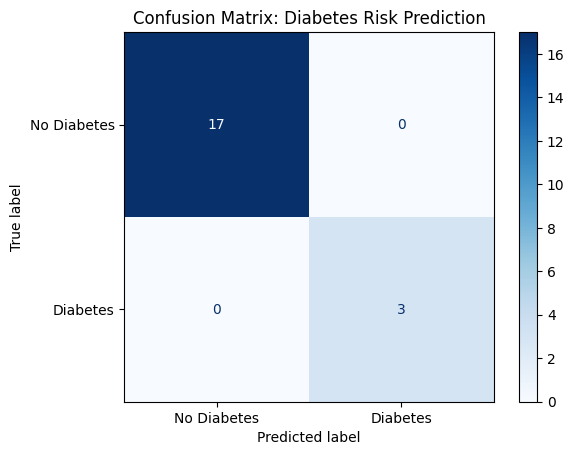

Model Coefficients (sorted):
                 Feature  Coefficient
7       disease_diabetes     3.666316
0                    age    -0.004299
1                 gender    -0.241209
2          symptom_count    -0.306887
3           entity_count    -0.436632
4           disease_COPD    -0.436632
8  disease_heart failure    -0.769058
9   disease_hypertension    -0.770615
6     disease_depression    -0.817216
5         disease_asthma    -0.873065


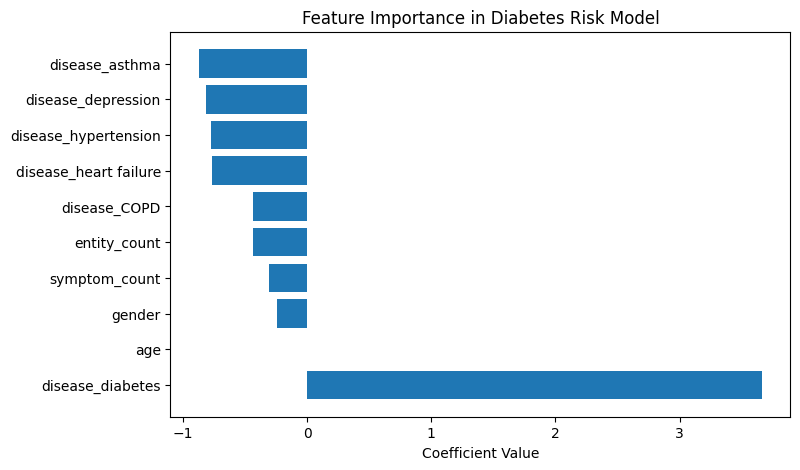

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Visualize confusion matrix
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=["No Diabetes", "Diabetes"], cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Diabetes Risk Prediction")
plt.show()

# Interpret model coefficients
feature_names = X.columns
coefficients = clf.coef_[0]
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
coef_df = coef_df.sort_values(by="Coefficient", ascending=False)
print("Model Coefficients (sorted):")
print(coef_df)

# Visualize coefficients
plt.figure(figsize=(8, 5))
plt.barh(coef_df["Feature"], coef_df["Coefficient"])
plt.xlabel("Coefficient Value")
plt.title("Feature Importance in Diabetes Risk Model")
plt.show()

### Model Evaluation: Confusion Matrix
The confusion matrix above shows the number of correct and incorrect predictions for diabetes risk. It helps assess how well the model distinguishes between patients with and without diabetes.
### Feature Importance: Model Coefficients
The bar plot and table display the coefficients learned by the logistic regression model. Positive values indicate features that increase the likelihood of diabetes, while negative values decrease it. This helps interpret which patient characteristics and extracted features are most predictive.

## Project Summary and Next Steps

This notebook demonstrates a clinical NLP and predictive modeling workflow using synthetic data. Key steps include:
- ETL and data cleaning for structured and unstructured clinical data
- Rule-based and spaCy-based NLP for phenotype and entity extraction
- Predictive modeling for disease risk using patient features and NLP outputs
- Model evaluation and interpretation with visualizations

**Clinical Relevance:**
- The workflow simulates real-world tasks in clinical research and healthcare analytics, such as identifying disease phenotypes and predicting patient risk.
- Feature importance analysis helps clinicians and researchers understand which factors contribute most to disease risk.

**Limitations:**
- Synthetic data may not capture all complexities of real clinical data.
- The NLP pipeline can be further improved with domain-specific models and negation/context handling.
- Predictive modeling can be enhanced with more features and advanced algorithms.

**Next Steps:**
- Integrate real or more complex synthetic datasets
- Expand NLP with custom entity recognition and context analysis
- Explore additional models (e.g., random forest, XGBoost)
- Add privacy/compliance checks and reporting modules

For questions or collaboration, please contact the project owner.


Hypertension Risk Prediction:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         8

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

ROC AUC: 1.0


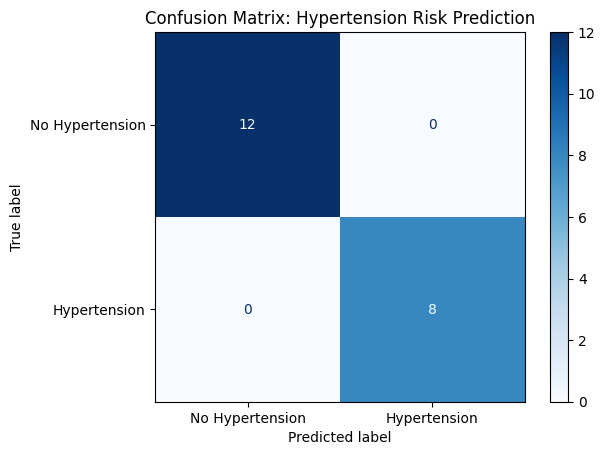

Model Coefficients (sorted):
                 Feature  Coefficient
9   disease_hypertension     3.575236
1                 gender     0.359741
2          symptom_count     0.099649
0                    age     0.023084
3           entity_count    -0.433463
4           disease_COPD    -0.433463
7       disease_diabetes    -0.651719
6     disease_depression    -0.785593
8  disease_heart failure    -0.785854
5         disease_asthma    -0.921757


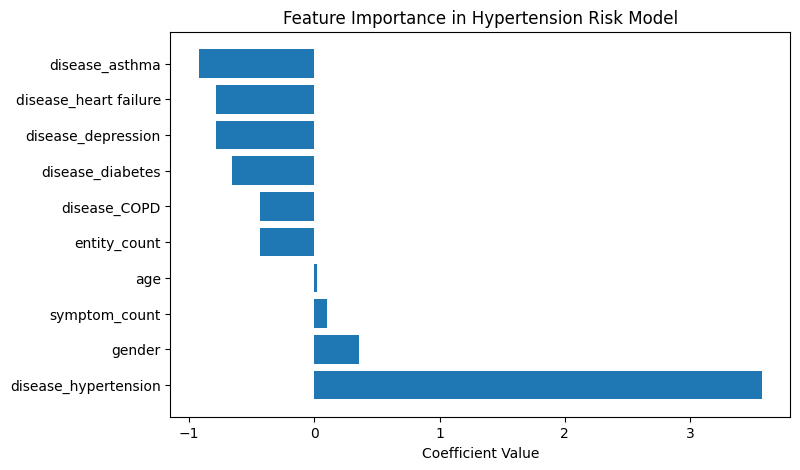


Asthma Risk Prediction:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         4

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

ROC AUC: 1.0


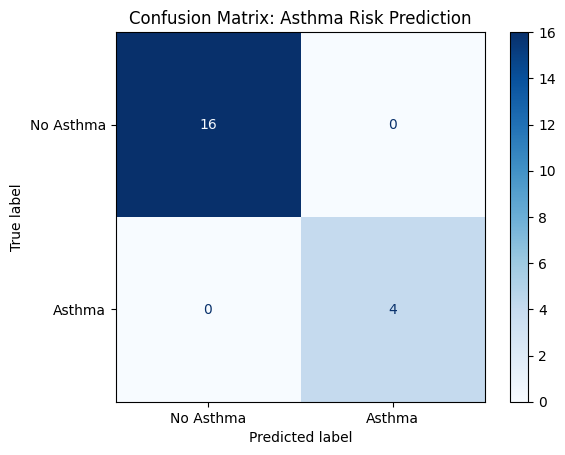

Model Coefficients (sorted):
                 Feature  Coefficient
5         disease_asthma     3.703734
2          symptom_count     0.035795
0                    age     0.003392
1                 gender    -0.224637
3           entity_count    -0.465070
4           disease_COPD    -0.465070
7       disease_diabetes    -0.715883
8  disease_heart failure    -0.801710
6     disease_depression    -0.844804
9   disease_hypertension    -0.871048


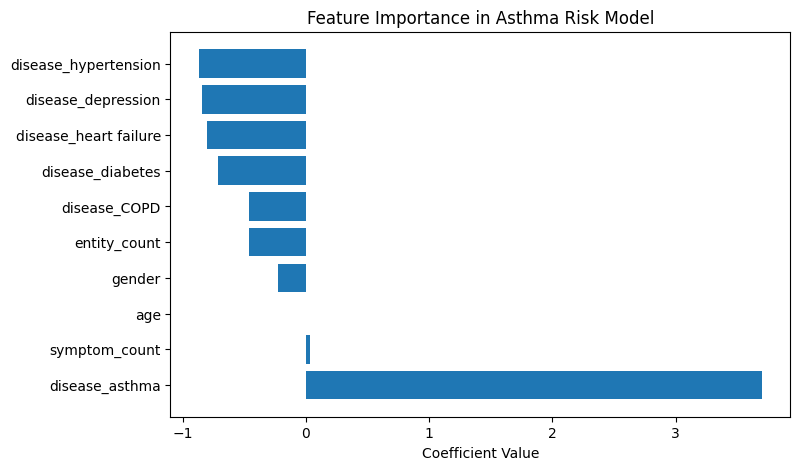

In [41]:
# Create binary targets for hypertension and asthma

df["hypertension_risk"] = (df["disease"] == "hypertension").astype(int)

df["asthma_risk"] = (df["disease"] == "asthma").astype(int)

# Features reused from previous modeling

features = X.columns

results = {}

for disease, target in zip(["Hypertension", "Asthma"], ["hypertension_risk", "asthma_risk"]):

    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = LogisticRegression(class_weight='balanced')

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    y_prob = clf.predict_proba(X_test)[:, 1]

    print(f"\n{disease} Risk Prediction:")

    print(classification_report(y_test, y_pred))

    print("ROC AUC:", roc_auc_score(y_test, y_prob))

    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=[f"No {disease}", disease], cmap=plt.cm.Blues)

    plt.title(f"Confusion Matrix: {disease} Risk Prediction")

    plt.show()

    # Feature importance

    feature_names = X.columns

    coefficients = clf.coef_[0]

    coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})

    coef_df = coef_df.sort_values(by="Coefficient", ascending=False)

    print("Model Coefficients (sorted):")

    print(coef_df)

    plt.figure(figsize=(8, 5))

    plt.barh(coef_df["Feature"], coef_df["Coefficient"])

    plt.xlabel("Coefficient Value")

    plt.title(f"Feature Importance in {disease} Risk Model")

    plt.show()

## Expanded Disease Risk Prediction

In addition to diabetes, we now predict risk for hypertension and asthma using the same feature engineering and modeling approach.

---
## Related Notebook: Agent Architectures & Protocols
For advanced agentic workflows, protocols, and context-aware architectures, see the companion notebook:
**clinical_nlp_agents_demo.ipynb**
This notebook demonstrates A2A protocols, Model Context Protocol (MCP), Retrieval-Augmented Generation (RAG), healthcare data standards, and vector memory integration for next-generation healthcare AI systems.